This is a tutorial on using a CNN or the deepChromaprocessor from madmom for Musical Key Detection on the GTZAN genre dataset. Download the gtzan genre dataset and brian lerch key annotation into your drive folder and load it.


First we have to load the gtzan dataset and extract the cqt spectrograms. We also pickle them for quick access.

In [0]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

import pickle

os.chdir("/content/drive/My Drive/S&I Tech - Thesis/colab/gtzan/genres") #path to the dataset

faudio = sorted(glob.glob("audio/*.wav")) #path to the audio
fclass = sorted(glob.glob("gtzan_key/*.lerch.txt")) #path to the annotations
N = len(faudio)

data = np.zeros((837,144,150))
target = np.zeros((837))


for i in range(0,N-1):
  audio,fs = librosa.load(str(faudio[i]),mono = True, duration = 30)

  audio = librosa.effects.pitch_shift(audio, fs, n_steps=1)

	#h_audio = librosa.effects.harmonic(audio)

	#tonnetz = librosa.feature.tonnetz(y=h_audio, sr=fs)

	#pd.write_csv(tonnetz,'tonnetz_test.csv')


  hpcp_series = librosa.core.hybrid_cqt(audio, sr=fs, bins_per_octave=24, n_bins=144, hop_length=int(fs / 5))
	
	#harmonic_series = np.argmax(hpcp_series[:,:],0)
	
  print(hpcp_series.shape)
	
  fc = open(str(fclass[i]),"r")
  
	
  Class = fc.read()
  print(Class)
  if int(Class) == -1:
    print("Unknown Class")
    continue
  Class = int(Class) + 1
  if  Class==12:
    Class = 0
  elif Class==24:
    Class = 12

  data[i]=hpcp_series[:,:150]
  target[i]=int(Class)

os.chdir('/content/drive/My Drive/S&I Tech - Thesis/colab/gtzan/genres/pickled/hybrid_cqt')
 
with open('input_aug.pkl','wb') as f:
  pickle.dump(data, f)

with open('output_aug.pkl','wb') as f:
  pickle.dump(target, f)
"""
	filename = os.path.split(faudio[i])[1]
	filename = os.path.splitext(filename)[0]
	
	
	newfile = "hybrid_cqt_chroma\\"+ filename +  "_" + Class
	
	fnew = open(newfile,"a+")
	
	np.savetxt(fnew,  hpcp_series, newline="\r ")
"""


We then also get the deepChroma using the madmom library


In [0]:
import madmom
import numpy as np
import pandas as pd
import os
import glob

os.chdir('/content/drive/My Drive/S&I Tech - Thesis/colab/gtzan/genres')

faudio = sorted(glob.glob("audio/*.wav"))
fclass = sorted(glob.glob("gtzan_key/*.lerch.txt"))
N = len(faudio)

for i in range(0,N):
  fc = open(str(fclass[i]),"r")
	
  Class = fc.read()
  Class = int(Class)
  #print(Class)
  if int(Class) == -1:
    print("Unknown class, skipping sample")
    continue

  dcp = madmom.audio.chroma.DeepChromaProcessor()
  chroma = dcp(faudio[i])
  chroma  # doctest: +NORMALIZE_WHITESPACE +ELLIPSIS
  chroma = chroma[:300,:]
  if chroma.shape[0] != 300:
    print("Error")
    print(chroma.shape[0])

  if int(Class) == 11:
    sharp_class = 0
  elif int(Class) == 23:
    sharp_class = 12
  else:
    sharp_class = Class + 1

  print(Class)
  print(sharp_class)
	
  filename = os.path.split(faudio[i])[1]
  filename = os.path.splitext(filename)[0]

	
  newfile = "deep_chroma/"+ filename +  "_" + str(Class) + '.csv'
  print(newfile)
	
  fnew = open(newfile,"a+")
	
  np.savetxt(fnew,chroma, newline="\r ")
  fnew.close()

Then we also preprocess the deepChroma matrices and pickle them for quick access

In [0]:
import numpy as np
import pickle
import glob
import os

os.chdir('/content/drive/My Drive/S&I Tech - Thesis/colab/gtzan/genres/deep_chroma')
faudio = sorted(glob.glob("*.csv"))
np.random.shuffle(faudio)

N = len(faudio)

dataset = np.zeros((N,300,12))
target  = np.zeros((N)) 

for i in range(0,N):
  target[i] = (faudio[i].split('_')[1]).split('.')[0]
  data = np.loadtxt(faudio[i])
	#print(data.shape)
  data = data[:300,:]
  dataset[i,:,:] = data
	
#index = np.where(target == -1)

print(data)

#dataset = np.delete(dataset,index,0)
#target = np.delete(target,index,0)
		
print(dataset.shape)
print(target.shape)

os.chdir('/content/drive/My Drive/S&I Tech - Thesis/colab/gtzan/genres/pickled/deep_chroma')

with open('input.pkl','wb') as f:
  pickle.dump(dataset, f)
    
with open('input.pkl','rb') as f:
  x = pickle.load(f)

print(x.shape)

with open('output.pkl','wb') as f:
  pickle.dump(target, f)
    
with open('output.pkl','rb') as f:
  x = pickle.load(f)

print(x.shape)


Next, we can run a simple Dense Netowork, by just averaging the deepChroma matrices over time. This results in a 76% accuracy, which is around the state of the art performance for this datset

In [0]:
#from __future__ import absolute_import, division, print_function, unicode_literals

##Achieves 65.44% cent on chromagrams of GTZAN

# TensorFlow and tf.keras
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import datasets, layers, models, regularizers, optimizers
import keras
import tensorflow
from tensorflow.keras import datasets, layers, models, regularizers, optimizers

# Helper libraries
import numpy as np
#import matplotlib.pyplot as plt
#import pandas as pd
import glob
import os
import pickle

os.chdir('/content/drive/My Drive/S&I Tech - Thesis/colab/gtzan/genres')

print(tensorflow.__version__)

n = 668

with open('pickled/deep_chroma/input.pkl','rb') as f:
  dataset = pickle.load(f)

with open('pickled/deep_chroma/output.pkl','rb') as f:
  target = pickle.load(f)

print(len(dataset))
p = np.random.permutation(len(dataset))

dataset = dataset[p]
target = target[p]

print(dataset.shape)
print(target.shape)

#dataset = np.expand_dims(dataset,axis=-1)
print(dataset.shape)
dataset = np.mean(dataset,1)
print(dataset.shape)

model = models.Sequential()

#model.add(layers.Conv1D(24,(12), activation='relu'))
#model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='elu'))
model.add(layers.Dense(128, activation='elu'))
model.add(layers.Dense(48, activation='elu'))
model.add(layers.Dense(24, activation='softmax'))

x = np.zeros((1,12))
y = np.zeros((1))

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


x_train = np.roll(dataset,1,axis=1)
y_train = target + 1
  #print(x_train.shape)
  #print(y_train)
  #print(target.values)

y_train[y_train == 12] = 0
y_train[y_train == 24] = 12

x_train_1 = np.roll(dataset,2,axis=1)
y_train_1 = target + 2
  #print(x_train.shape)
  #print(y_train)
  #print(target.values)

y_train_1[y_train_1 == 13] = 1
y_train_1[y_train_1 == 25] = 13
y_train_1[y_train_1 == 12] = 0
y_train_1[y_train_1 == 24] = 12

x = np.concatenate((x,x_train),0)
y = np.concatenate((y,y_train),0)

x = x[1:]
y = y[1:]
  
print("\nTraining")



for i in range(0,50):
  #model.fit(dataset[:n,:], target[:n], epochs=10,verbose=0)	
  model.fit(np.concatenate((dataset[:n],x_train, x_train_1)),  np.concatenate((target[:n],y_train, y_train_1,)) , epochs=10, verbose=0)
  model.fit(np.concatenate((x_train, x_train_1)),  np.concatenate((y_train, y_train_1,)) , epochs=10, verbose=0)
  #model.fit(x,y , epochs=10, verbose=0)
  
  print("\nModel Trained, Evaluation: \n")
  model.evaluate(dataset[n+1:], target[n+1:], verbose=2)
  #model.evaluate(dataset, target, verbose=2)
  y = model.predict(dataset[n+1:])
  gt = target[n+1:]
  Mirex_score = 0
  asd = 0
  print(n)
  m = 168
  for i in range(0,m):
    dev = np.argmax(y[i]) - gt[i]
    if dev == 0 :
      Mirex_score = Mirex_score+1	
      asd += 1
    if abs(dev) == 12:
      Mirex_score = Mirex_score+0.2
    if dev%12 == 7 and (np.argmax(y[i])-gt[i])<12:
      Mirex_score = Mirex_score+0.5
    if dev%12 == 9 and (np.argmax(y[i])>11) and (gt[i]<12):
      Mirex_score = Mirex_score+0.3
    if dev%12 == 3 and (np.argmax(y[i])<12) and (gt[i]>11):
      Mirex_score = Mirex_score+0.3
  print("MIREX SCORE")
  print(Mirex_score/m)	


1.15.0
837
(837, 300, 12)
(837,)
(837, 300, 12)
(837, 12)

Training

Model Trained, Evaluation: 

168/168 - 0s - loss: 1.6117 - acc: 0.6071
668
MIREX SCORE
0.7047619047619049

Model Trained, Evaluation: 

168/168 - 0s - loss: 1.0880 - acc: 0.7143
668
MIREX SCORE
0.7684523809523811

Model Trained, Evaluation: 

168/168 - 0s - loss: 1.0275 - acc: 0.7440
668
MIREX SCORE
0.7910714285714286

Model Trained, Evaluation: 

168/168 - 0s - loss: 1.0042 - acc: 0.7440
668
MIREX SCORE
0.793452380952381

Model Trained, Evaluation: 

168/168 - 0s - loss: 0.9947 - acc: 0.7500
668
MIREX SCORE
0.7964285714285715

Model Trained, Evaluation: 

168/168 - 0s - loss: 0.9752 - acc: 0.7440
668
MIREX SCORE
0.7976190476190477

Model Trained, Evaluation: 

168/168 - 0s - loss: 0.9629 - acc: 0.7321
668
MIREX SCORE
0.7904761904761906

Model Trained, Evaluation: 

168/168 - 0s - loss: 0.9513 - acc: 0.7381
668
MIREX SCORE
0.7946428571428571

Model Trained, Evaluation: 

168/168 - 0s - loss: 0.9291 - acc: 0.7500
668
M

KeyboardInterrupt: ignored

Then we can also run a fully convolutional CNN using the CQ-Transform chroma matrices. This results in a similar accuracy as before, albeit with a much more costly training cycle.

1.15.0
837
(837, 144, 150, 1)
(837,)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 150, 24)      624       
_________________________________________________________________
batch_normalization (BatchNo (None, 144, 150, 24)      96        
_________________________________________________________________
dropout (Dropout)            (None, 144, 150, 24)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 150, 24)      14424     
_________________________________________________________________
batch_normalization_1 (Batch (None, 144, 150, 24)      96        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 144, 150, 24)      14424     
____

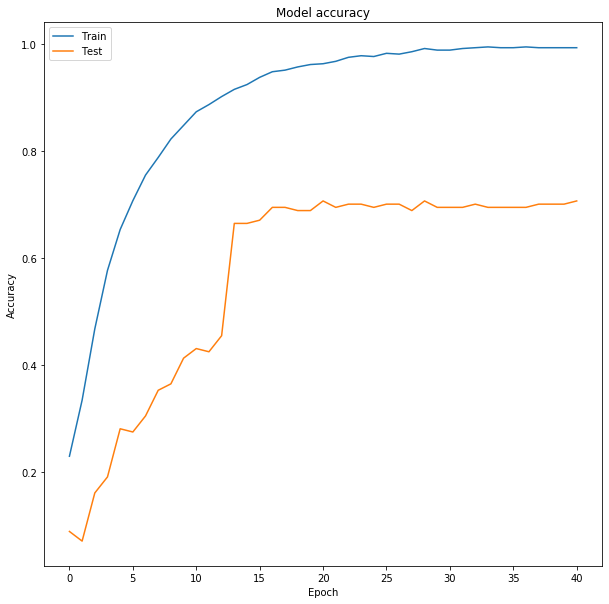

167/167 - 0s - loss: 1.2844 - acc: 0.7066


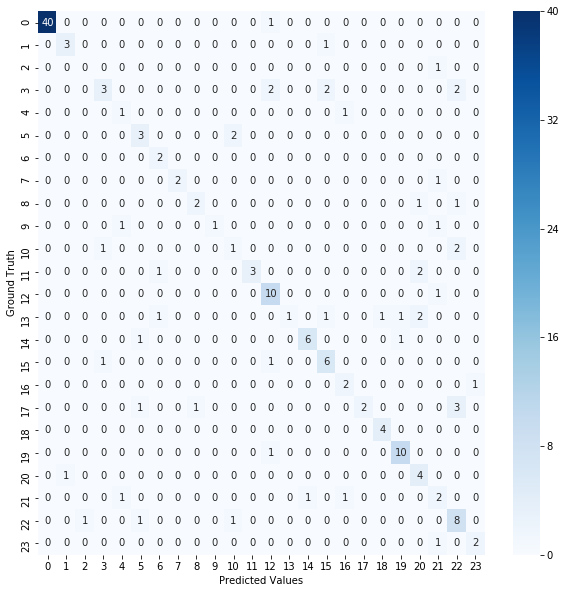


Evaluation accuracy: 70.66 % - loss: 1.28
669


IndexError: ignored

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

##Achieves 65.44% cent on chromagrams of GTZAN

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers, optimizers, callbacks


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd
import glob
import os
import pickle
import sklearn

os.chdir("/content/drive/My Drive/S&I Tech - Thesis/colab/gtzan/genres")

print(tf.__version__)

n = 669

with open('pickled/hybrid_cqt/input.pkl','rb') as f:
  dataset = pickle.load(f)

with open('pickled/hybrid_cqt/output.pkl','rb') as f:
  target = pickle.load(f)

p = np.random.permutation(len(dataset))

dataset = dataset[p]
target = target[p]

N = len(target)
dataset = np.expand_dims(dataset,axis=-1)
print(N)		
print(dataset.shape)
print(target.shape)

model = models.Sequential()
model.add(layers.Conv2D(24, (5,5), kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same', input_shape=(144,150,1)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
#model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same'))
#model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same'))
#model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())
#model.add(layers.Activation('elu'))
model.add(layers.AveragePooling2D(pool_size = (1,150)))
model.add(layers.Flatten())

model.add(layers.Dense(48, activation='relu'))
model.add(layers.Dense(24, activation='softmax'))

model.summary()
sgd = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.9)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\nTraining")

callback = [callbacks.EarlyStopping(monitor='val_acc', patience=20, restore_best_weights=True) , callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
#callback_lr = [callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
	  
history = model.fit(dataset[:n,:,:], target[:n], epochs=60,verbose=1,validation_data = (dataset[n+1:,:,:], target[n+1:]),callbacks=callback)

					
print("\nModel Trained, Evaluation: \n")
figure = plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
loss, acc = model.evaluate(dataset[n+1:,:,:], target[n+1:], verbose=2)


if True:
  y_pred = model.predict(dataset[n+1:,:,:])
  matrix = sklearn.metrics.confusion_matrix(keras.utils.to_categorical(target[n+1:]).argmax(axis=1), y_pred.argmax(axis=1))
  figure = plt.figure(figsize=(10, 10))
  import seaborn as sns
  sns.heatmap(matrix, annot=True, cmap = plt.cm.Blues)
  plt.xlabel('Predicted Values')
  plt.ylabel('Ground Truth')
  plt.show()

print('\nEvaluation accuracy: %.2f %% - loss: %.2f' % (acc*100, loss))


